In [1]:
!pip install radon pydriller -q 


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from pydriller import Repository
import pandas as pd
import matplotlib.pyplot as plt

from radon.metrics import mi_visit
from radon.complexity import cc_visit
from radon.raw import analyze

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import sacrebleu

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
df = pd.read_csv("/diff_analysis.csv")

### Categorize LLM Inferences to Fix Types
In the previous assignment, we got the LLM Inference for commit message based on diff. For this assignment, we need to find the distribution of Fix Types. So, we categorize the llm inference based on keywords to different fix types.

In [13]:
def classify_fix_type(message: str) -> str:
    msg = str(message).lower()
    if any(word in msg for word in ["fix", "bug", "error", "refactor", "issue"]):
        return "Bug"
    elif any(word in msg for word in ["add", "implement", "feature", "support"]):
        return "Feature"
    elif any(word in msg for word in ["doc", "readme", "comment", "format", "documentation"]):
        return "Documentation"
    elif any(word in msg for word in ["test", "unittest", "assert", "coverage"]):
        return "Test"
    else:
        return "Other"
    
df["Fix Type"] = df["llm_inference"].apply(classify_fix_type)

## Compute Baseline Statistics

In [8]:
# Total number of commits and files
total_commits = df["hash"].nunique()
total_files = df["filename"].nunique()

print(f"Total number of commits: {total_commits}")
print(f"Total number of modified files: {total_files}")

Total number of commits: 1175
Total number of modified files: 835


In [9]:
# Average number of modified files per commit
files_per_commit = df.groupby("hash")["filename"].value_counts()
avg_files_per_commit = files_per_commit.mean()
print(f"Average modified files per commit: {avg_files_per_commit:.2f}\n")

Average modified files per commit: 1.06



In [14]:
# Distribution of fix types from LLM Inference
fix_type_distribution = df["Fix Type"].value_counts()
print("Distribution of Fix Types:")
print(fix_type_distribution, "\n")

Distribution of Fix Types:
Fix Type
Feature          3267
Other             520
Bug               247
Documentation      15
Test               12
Name: count, dtype: int64 



In [11]:
# Most frequently modified filenames/extensions
df["Extension"] = df["filename"].str.extract(r"(\.[^\.]+)$")
filename_counts = df["filename"].value_counts().head(5)
extension_counts = df["Extension"].value_counts().head(5)

print("Most Frequently Modified Filenames:")
print(filename_counts, "\n")

print("Most Frequently Modified File Extensions:")
print(extension_counts)

Most Frequently Modified Filenames:
filename
README.md      239
__init__.py    181
utils.py       120
trainer.py      91
train.py        83
Name: count, dtype: int64 

Most Frequently Modified File Extensions:
Extension
.py      3424
.md       320
.yaml     152
.sh        56
.yml       30
Name: count, dtype: int64


### Plots for baseline statistics

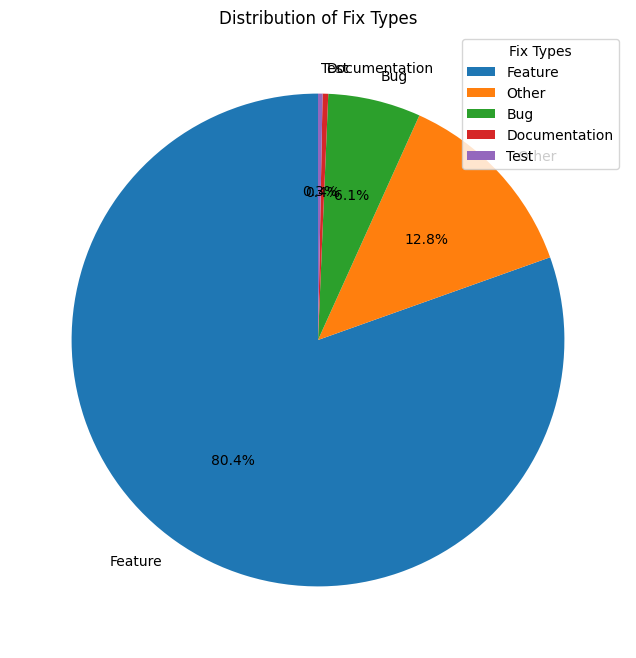

In [ ]:
# Pie chart for distribution of fix types
fix_type_distribution.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(8, 8))
plt.title("Distribution of Fix Types")
plt.ylabel("")

plt.legend(title="Fix Types", loc="upper right")
plt.show()

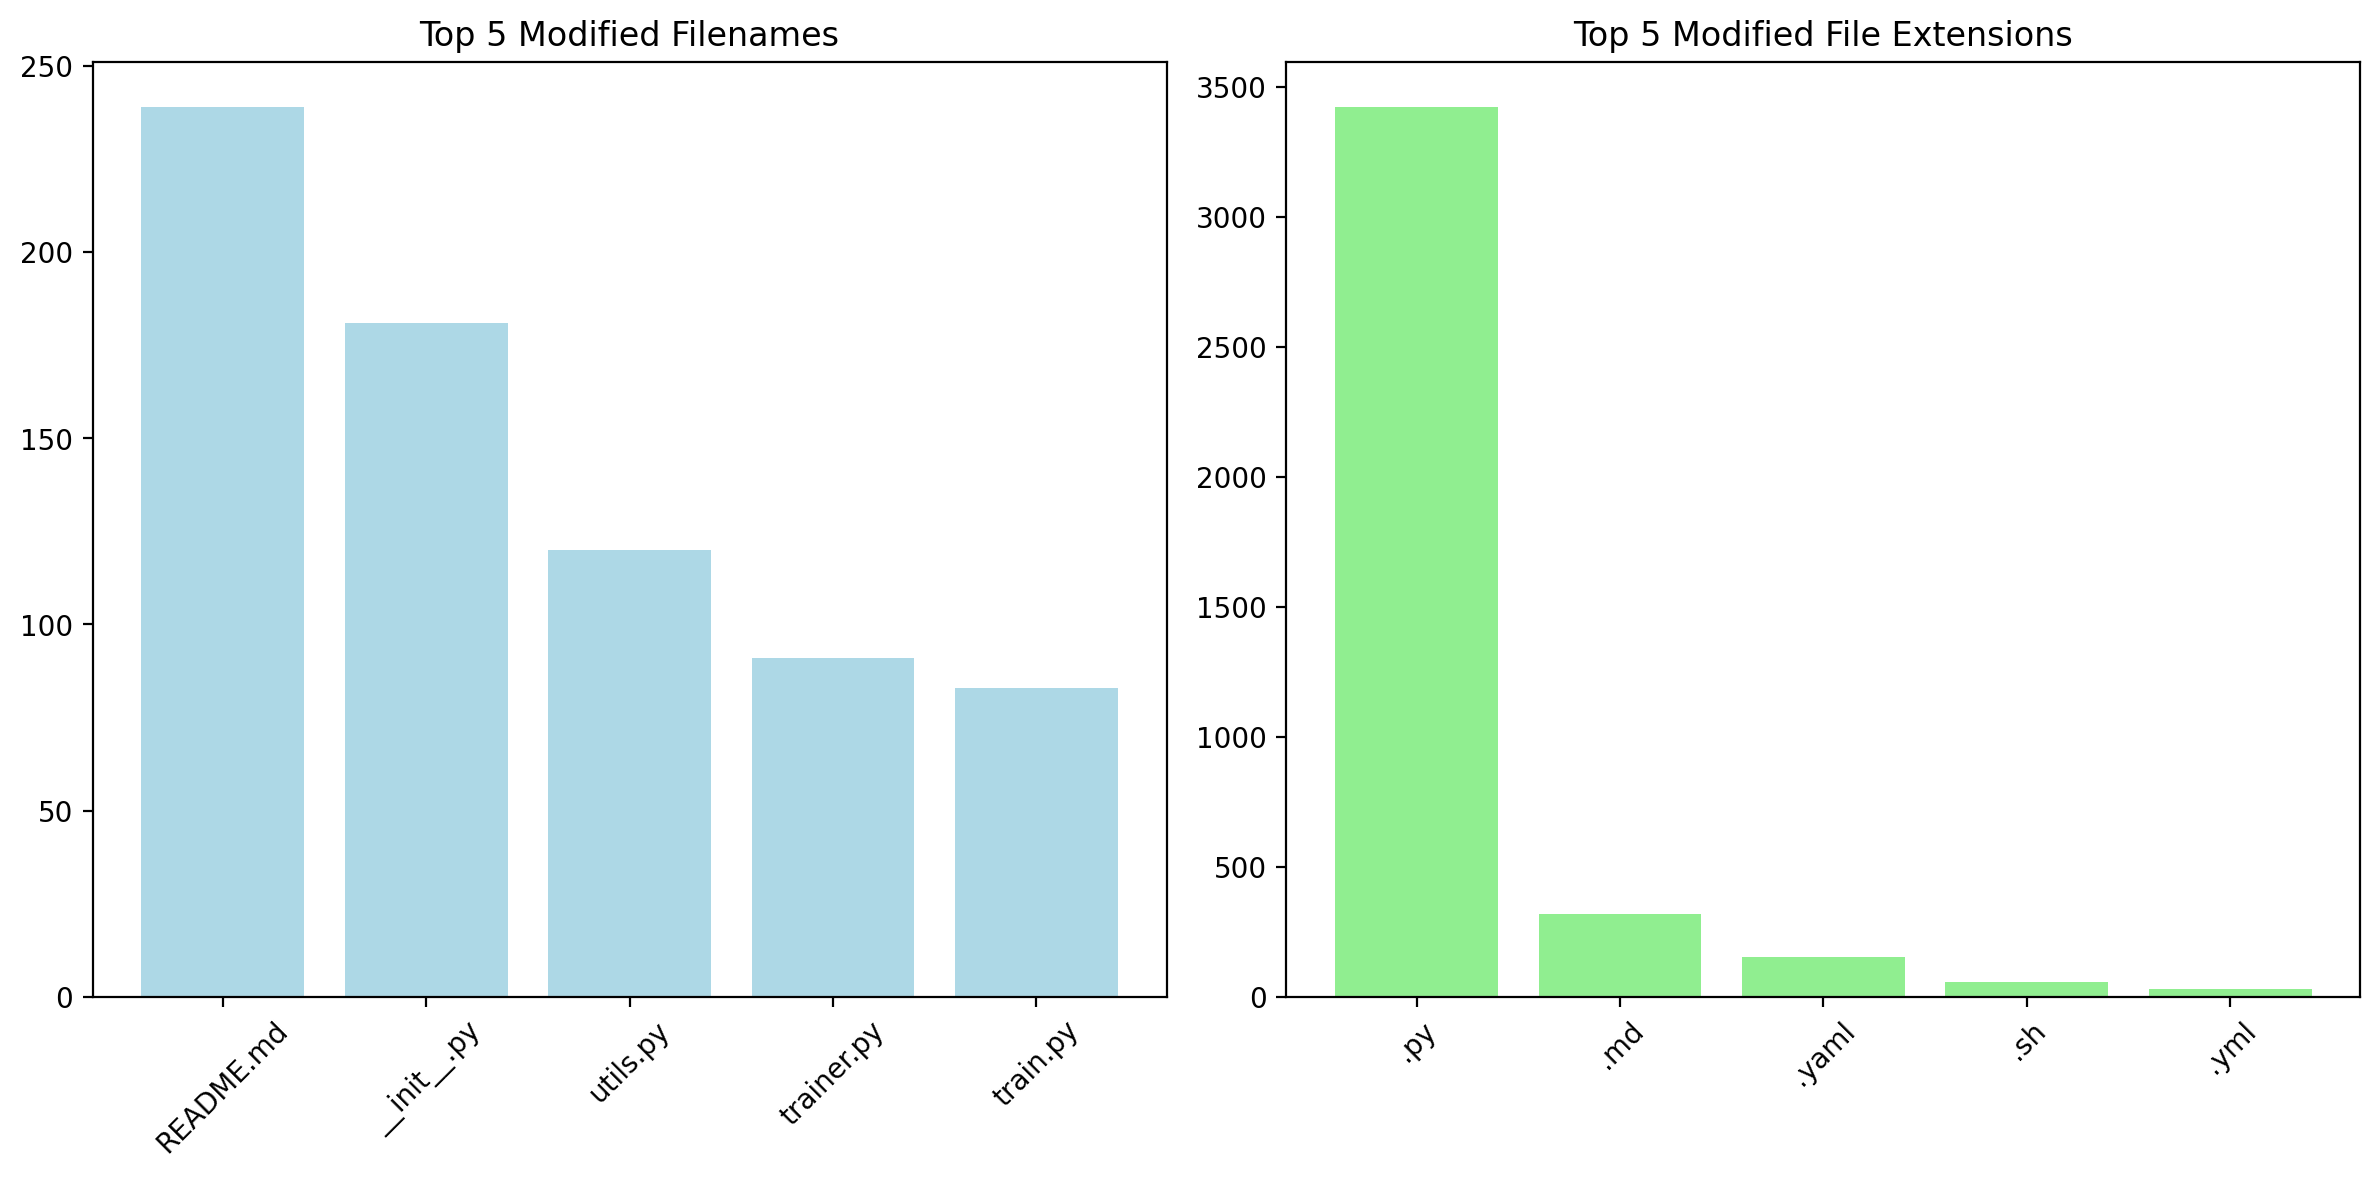

In [ ]:
# Top 5 most frequently modified filenames and extensions
top_filenames = filename_counts.head(5)
top_extensions = extension_counts.head(5)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(top_filenames.index, top_filenames.values, color='lightblue')
plt.title("Top 5 Modified Filenames")
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.bar(top_extensions.index, top_extensions.values, color='lightgreen')
plt.title("Top 5 Modified File Extensions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Compute Structural Change Metrics

In [ ]:
def get_metrics(code):
    try:
        if not isinstance(code, str) or code.strip() == "":
            return 0, 0, 0

        # Maintainability Index
        mi = mi_visit(code, True)

        # Cyclomatic Complexity
        cc_results = cc_visit(code)
        cc = sum([block.complexity for block in cc_results]) / len(cc_results) if cc_results else 0

        # LOC (Lines of Code)
        raw_metrics = analyze(code)
        loc = raw_metrics.loc

        return mi, cc, loc
    except Exception as e:
        return 0, 0, 0

# Compute metrics for before/after
df["MI_Before"], df["CC_Before"], df["LOC_Before"] = zip(*df["source_code_before"].map(get_metrics))
df["MI_After"],  df["CC_After"],  df["LOC_After"]  = zip(*df["source_code_after"].map(get_metrics))

# Compute changes
df["MI_Change"]  = df["MI_After"]  - df["MI_Before"]
df["CC_Change"]  = df["CC_After"]  - df["CC_Before"]
df["LOC_Change"] = df["LOC_After"] - df["LOC_Before"]

df.to_csv("diff_analysis_with_metrics.csv", index=False)

print("Metrics added and saved to diff_analysis_with_metrics.csv")

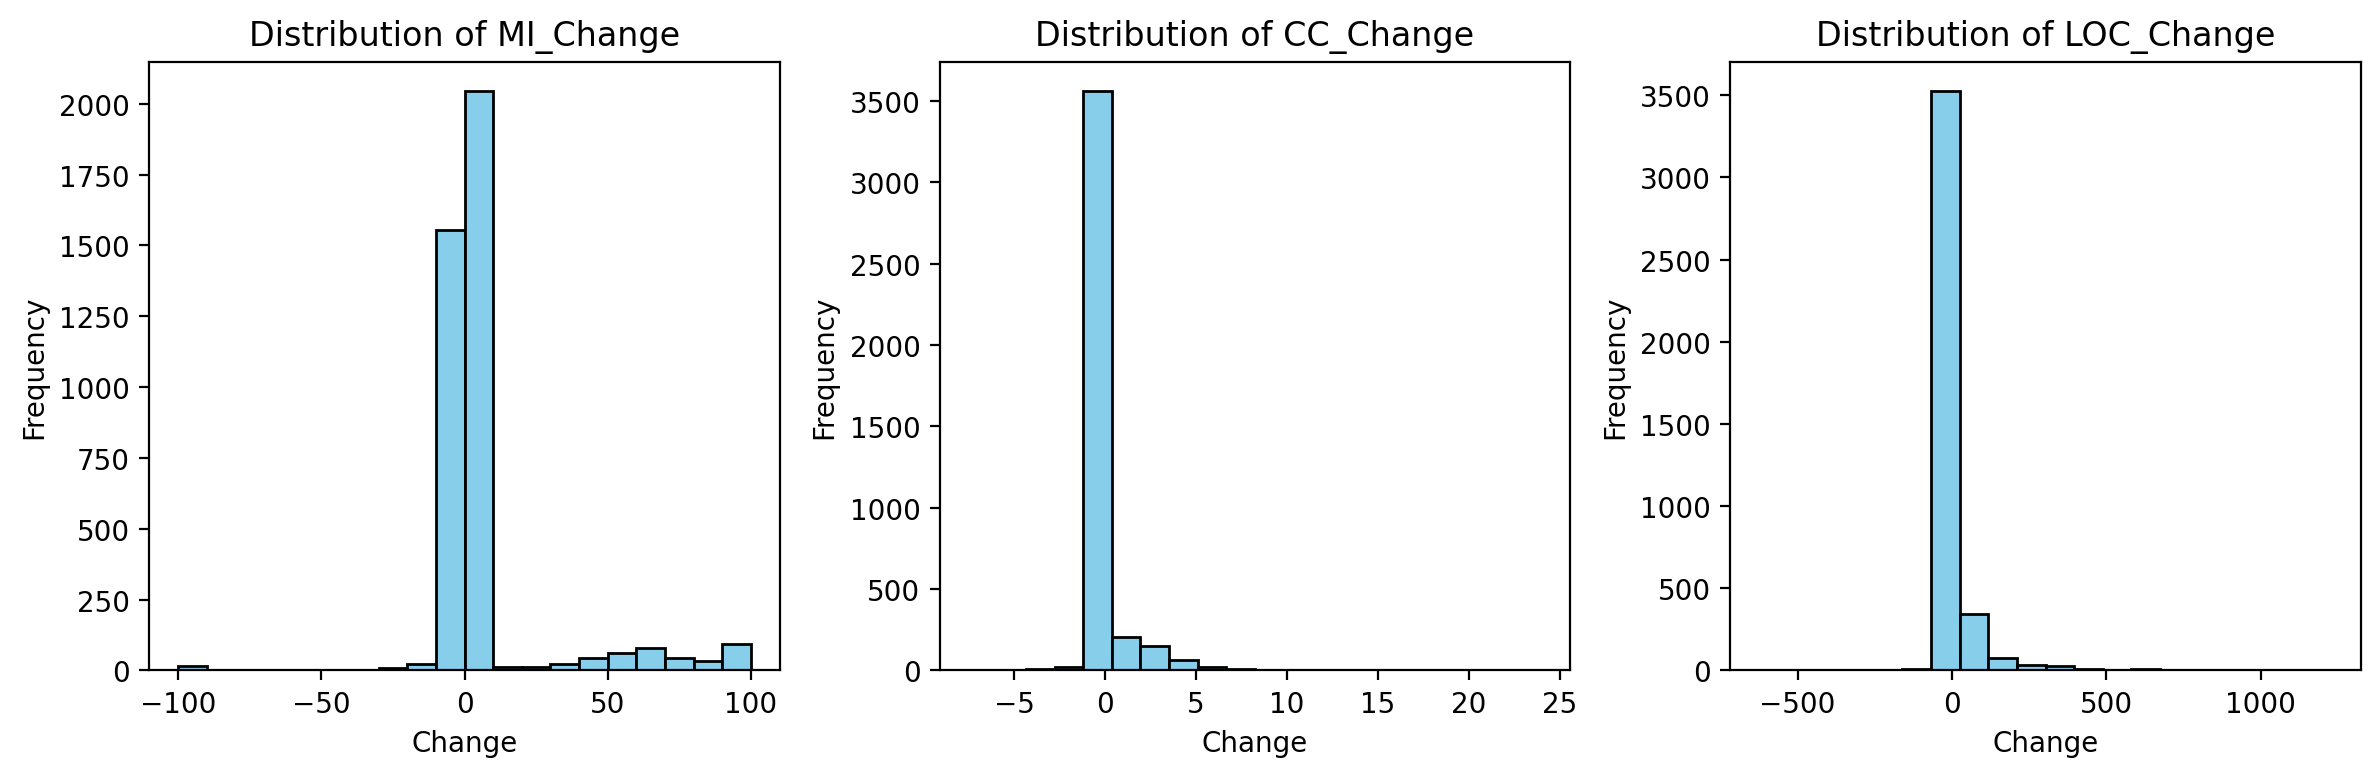

In [ ]:
# Plot the changes in MI, CC, LOC
metrics = ["MI_Change", "CC_Change", "LOC_Change"]
plt.figure(figsize=(12, 4))
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    plt.hist(df[metric], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {metric}")
    plt.xlabel("Change")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Compute Semantic Similarity Metrics

In [ ]:
# Load dataset with metrics
df = pd.read_csv("diff_analysis_with_metrics.csv")

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base").to(device)

# CodeBERT embeddings
def get_codebert_embedding(code: str):
    if not isinstance(code, str) or code.strip() == "":
        return torch.zeros(768)
    inputs = tokenizer(code, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].squeeze().cpu()

# Cosine similarity 
def cosine_sim(a, b):
    if a.norm() == 0 or b.norm() == 0:
        return 0.0
    return torch.nn.functional.cosine_similarity(a, b, dim=0).item()

# BLEU score with SacreBLEU
def compute_bleu(before: str, after: str):
    if not isinstance(before, str) or not isinstance(after, str):
        return 0.0

    bleu = sacrebleu.sentence_bleu(after, [before])
    return bleu.score / 100.0   # normalize to [0,1]

semantic_sims = []
token_sims = []

for _, row in df.iterrows():
    emb_before = get_codebert_embedding(row["source_code_before"])
    emb_after  = get_codebert_embedding(row["source_code_after"])

    semantic_sims.append(cosine_sim(emb_before, emb_after))
    token_sims.append(compute_bleu(str(row["source_code_before"]), str(row["source_code_after"])))

df["Semantic_Similarity"] = semantic_sims
df["Token_Similarity"] = token_sims

# Save updated dataset
df.to_csv("diff_analysis_with_change_magnitude.csv", index=False)
print("Added Semantic_Similarity and Token_Similarity columns using CodeBERT + SacreBLEU.")


c:\ProgramData\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv("diff_analysis_with_change_magnitude.csv")

df["Semantic Class"] = df["Token_Similarity"].apply(lambda x: "Major" if x >= 0.8 else "Minor")
df["Token Class"] = df["Token_Similarity"].apply(lambda x: "Major" if x >= 0.75 else "Minor")

df.to_csv("diff_analysis_with_change_magnitude.csv", index=False)

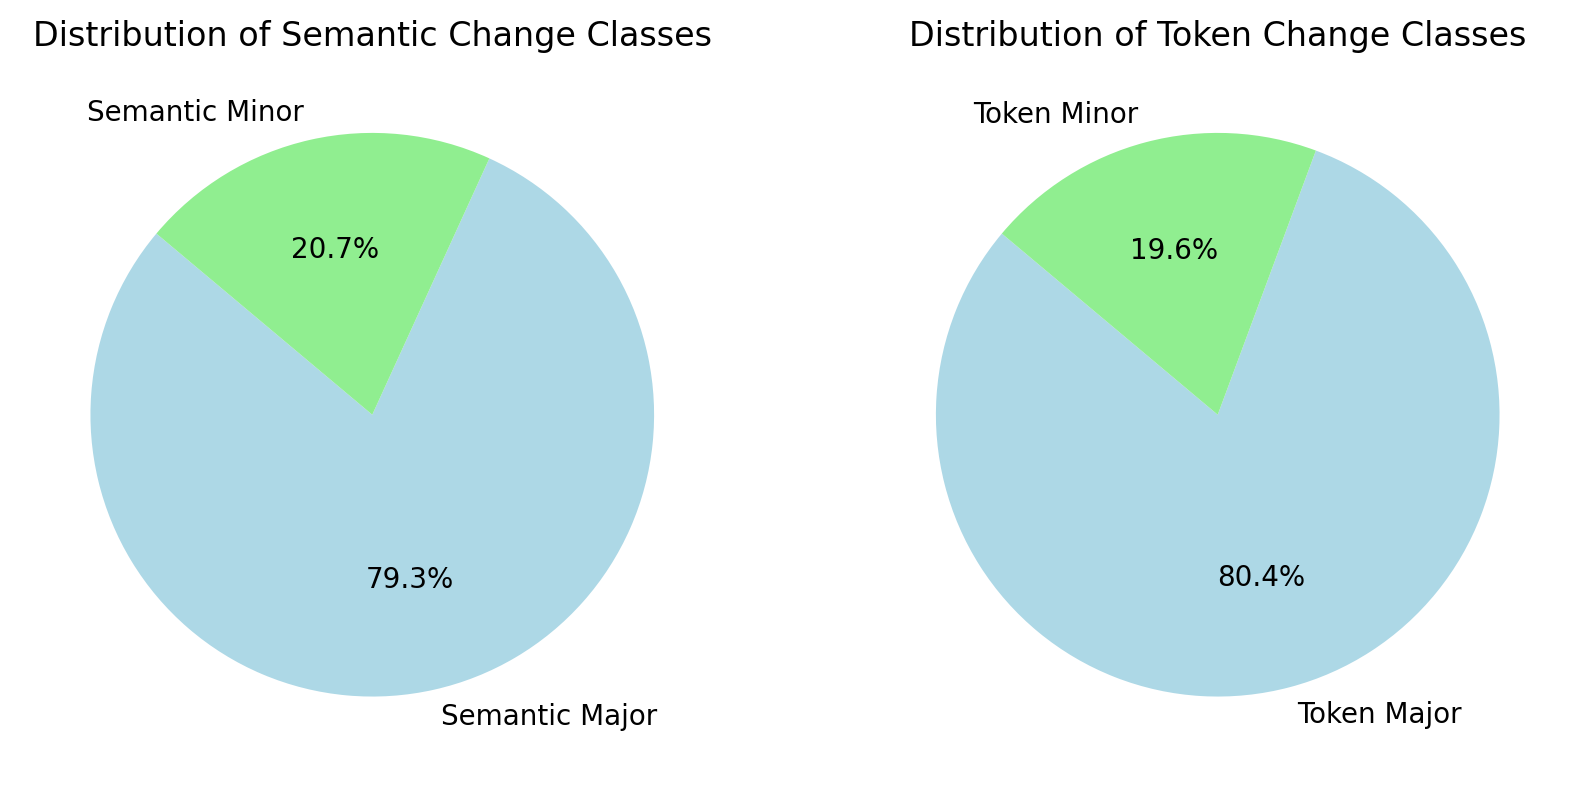

In [ ]:
# Plot the graph comparing the distribution of semantic and token similarity classes
total_changes = len(df)
semantic_major_count = (df["Semantic Class"] == "Major").sum()
semantic_minor_count = total_changes - semantic_major_count
token_major_count = (df["Token Class"] == "Major").sum()
token_minor_count = total_changes - token_major_count

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.pie([semantic_major_count, semantic_minor_count], labels=["Semantic Major", "Semantic Minor"], autopct='%1.1f%%', startangle=140, colors=["lightblue", "lightgreen"])
plt.title("Distribution of Semantic Change Classes")
plt.subplot(1, 2, 2)
plt.pie([token_major_count, token_minor_count], labels=["Token Major", "Token Minor"], autopct='%1.1f%%', startangle=140, colors=["lightblue", "lightgreen"])
plt.title("Distribution of Token Change Classes")
plt.show()

In [15]:
mismatch = len(df[df["Semantic Class"] != df["Token Class"]])
print("Number of mismatches between Semantic and Token classifications:", mismatch)

Number of mismatches between Semantic and Token classifications: 47
